# Model Parallelism

## Single-Machine Model Parallel


Model parallel is widely-used in distributed training techniques. Into the previous notebook we have explained how to use [DataParallelism](01-Data_Parallelism.ipynb) to train a neural network on multiple GPUs; this feature replicates the same model to all GPUs, where each GPU consumes a different partition of the input data. Although it can significantly accelerate the training process, it does not work for some use cases where the model is too large to fit into a single GPU. This shows how to solve that problem by using **model parallelism**, which, in contrast to `DataParallel`, splits a single model onto different GPUs, rather than replicating the entire model on each GPU (to be concrete, say a model `m` contains 10 layers: when using `DataParallel`, each GPU will have a replica of each of these 10 layers, whereas when using model parallel on two GPUs, each GPU could host 5 layers).

The high-level idea of model parallel is to place different sub-networks of a model onto different devices, and implement the `forward pass` method accordingly to move intermediate outputs across devices. As only part of a model operates on any individual device, a set of devices can collectively serve a larger model. This notebook focuses on showing the idea of model parallel. 

### Basic Usage

Let us start with a toy model that contains two linear layers. To run this model on two GPUs, simply put each linear layer on a different GPU, and move inputs and intermediate outputs to match the layer devices accordingly.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim


class ToyModel(nn.Module):
    def __init__(self):
        super(ToyModel, self).__init__()
        self.net1 = torch.nn.Linear(10, 10).to('cuda:0')
        self.relu = torch.nn.ReLU()
        self.net2 = torch.nn.Linear(10, 5).to('cuda:1')

    def forward(self, x):
        x = self.relu(self.net1(x.to('cuda:0')))
        return self.net2(x.to('cuda:1'))

Note that, the above ``ToyModel`` looks very similar to how one would
implement it on a single GPU, except the four ``to(device)`` calls which
place linear layers and tensors on proper devices. That is the only place in
the model that requires changes. The ``backward()`` and ``torch.optim`` will
automatically take care of gradients as if the model is on one GPU. You only
need to make sure that the labels are on the same device as the outputs when
calling the loss function.



In [4]:
model = ToyModel()
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

optimizer.zero_grad()
outputs = model(torch.randn(20, 10))
labels = torch.randn(20, 5).to('cuda:1')
loss_fn(outputs, labels).backward()
optimizer.step()

Apply Model Parallel to Existing Modules
----------------------------------------

It is also possible to run an existing single-GPU module on multiple GPUs
with just a few lines of changes. The code below shows how to decompose
``torchvision.models.resnet50()`` to two GPUs. The idea is to inherit from
the existing ``ResNet`` module, and split the layers to two GPUs during
construction. Then, override the ``forward`` method to stitch two
sub-networks by moving the intermediate outputs accordingly.



In [5]:
from torchvision.models.resnet import ResNet, Bottleneck

num_classes = 1000

class ModelParallelResNet50(ResNet):
    def __init__(self, *args, **kwargs):
        super(ModelParallelResNet50, self).__init__(
            Bottleneck, [3, 4, 6, 3], num_classes=num_classes, *args, **kwargs)

        self.seq1 = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.maxpool,

            self.layer1,
            self.layer2
        ).to('cuda:0')

        self.seq2 = nn.Sequential(
            self.layer3,
            self.layer4,
            self.avgpool,
        ).to('cuda:1')

        self.fc.to('cuda:1')

    def forward(self, x):
        x = self.seq2(self.seq1(x).to('cuda:1'))
        return self.fc(x.view(x.size(0), -1))

The above implementation solves the problem for cases where the model is too
large to fit into a single GPU. However, you might have already noticed that
it will be slower than running it on a single GPU if your model fits. It is
because, at any point in time, only one of the two GPUs are working, while
the other one is sitting there doing nothing. The performance further
deteriorates as the intermediate outputs need to be copied from ``cuda:0`` to
``cuda:1`` between ``layer2`` and ``layer3``.

Let us run an experiment to get a more quantitative view of the execution
time. In this experiment, we train ``ModelParallelResNet50`` and the existing
``torchvision.models.resnet50()`` by running random inputs and labels through
them. After the training, the models will not produce any useful predictions,
but we can get a reasonable understanding of the execution times.



In [6]:
import torchvision.models as models

num_batches = 3
batch_size = 120
image_w = 128
image_h = 128


def train(model):
    model.train(True)
    loss_fn = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001)

    one_hot_indices = torch.LongTensor(batch_size) \
                           .random_(0, num_classes) \
                           .view(batch_size, 1)

    for _ in range(num_batches):
        # generate random inputs and labels
        inputs = torch.randn(batch_size, 3, image_w, image_h)
        labels = torch.zeros(batch_size, num_classes) \
                      .scatter_(1, one_hot_indices, 1)

        # run forward pass
        optimizer.zero_grad()
        outputs = model(inputs.to('cuda:0'))

        # run backward pass
        labels = labels.to(outputs.device)
        loss_fn(outputs, labels).backward()
        optimizer.step()

The ``train(model)`` method above uses ``nn.MSELoss`` as the loss function,
and ``optim.SGD`` as the optimizer. It mimics training on ``128 X 128``
images which are organized into 3 batches where each batch contains 120
images. Then, we use ``timeit`` to run the ``train(model)`` method 10 times
and plot the execution times with standard deviations.



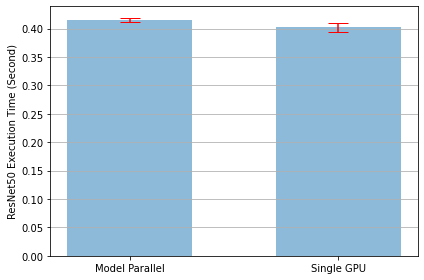

In [11]:
import matplotlib.pyplot as plt
plt.switch_backend('Agg')
import numpy as np
import timeit

num_repeat = 10

stmt = "train(model)"

setup = "model = ModelParallelResNet50()"
mp_run_times = timeit.repeat(
    stmt, setup, number=1, repeat=num_repeat, globals=globals())
mp_mean, mp_std = np.mean(mp_run_times), np.std(mp_run_times)

setup = "import torchvision.models as models;" + \
        "model = models.resnet50(num_classes=num_classes).to('cuda:0')"
rn_run_times = timeit.repeat(
    stmt, setup, number=1, repeat=num_repeat, globals=globals())
rn_mean, rn_std = np.mean(rn_run_times), np.std(rn_run_times)


def plot(means, stds, labels, fig_name):
    %matplotlib inline
    fig, ax = plt.subplots()
    ax.bar(np.arange(len(means)), means, yerr=stds,
           align='center', alpha=0.5, ecolor='red', capsize=10, width=0.6)
    ax.set_ylabel('ResNet50 Execution Time (Second)')
    ax.set_xticks(np.arange(len(means)))
    ax.set_xticklabels(labels)
    ax.yaxis.grid(True)
    plt.tight_layout()
    plt.savefig(fig_name)
    plt.show()
    plt.close(fig)


plot([mp_mean, rn_mean],
     [mp_std, rn_std],
     ['Model Parallel', 'Single GPU'],
     'mp_vs_rn.png')

The result shows that the execution time of model parallel implementation is
``4.02/3.75-1=7%`` longer than the existing single-GPU implementation. So we
can conclude there is roughly 7% overhead in copying tensors back and forth
across the GPUs. There are rooms for improvements, as we know one of the two
GPUs is sitting idle throughout the execution. One option is to further
divide each batch into a pipeline of splits, such that when one split reaches
the second sub-network, the following split can be fed into the first
sub-network. In this way, two consecutive splits can run concurrently on two
GPUs.



Speed Up by Pipelining Inputs
-----------------------------

In the following experiments, we further divide each 120-image batch into
20-image splits. As PyTorch launches CUDA operations asynchronously, the
implementation does not need to spawn multiple threads to achieve
concurrency.



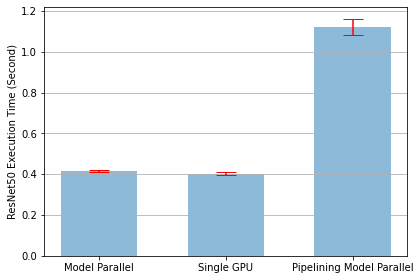

In [17]:
class PipelineParallelResNet50(ModelParallelResNet50):
    def __init__(self, split_size=10, *args, **kwargs):
        super(PipelineParallelResNet50, self).__init__(*args, **kwargs)
        self.split_size = split_size

    def forward(self, x):
        splits = iter(x.split(self.split_size, dim=0))
        s_next = next(splits)
        s_prev = self.seq1(s_next).to('cuda:1')
        ret = []

        for s_next in splits:
            # A. s_prev runs on cuda:1
            s_prev = self.seq2(s_prev)
            ret.append(self.fc(s_prev.view(s_prev.size(0), -1)))

            # B. s_next runs on cuda:0, which can run concurrently with A
            s_prev = self.seq1(s_next).to('cuda:1')

        s_prev = self.seq2(s_prev)
        ret.append(self.fc(s_prev.view(s_prev.size(0), -1)))

        return torch.cat(ret)


setup = "model = PipelineParallelResNet50()"
pp_run_times = timeit.repeat(
    stmt, setup, number=1, repeat=num_repeat, globals=globals())
pp_mean, pp_std = np.mean(pp_run_times), np.std(pp_run_times)

plot([mp_mean, rn_mean, pp_mean],
     [mp_std, rn_std, pp_std],
     ['Model Parallel', 'Single GPU', 'Pipelining Model Parallel'],
     'mp_vs_rn_vs_pp.png')

Please note, device-to-device tensor copy operations are synchronized on current streams on the source and the destination devices. If you create
multiple streams, you have to make sure that copy operations are properly synchronized. Writing the source tensor or reading/writing the destination
tensor before finishing the copy operation can lead to undefined behavior. The above implementation only uses default streams on both source and
destination devices, hence it is not necessary to enforce additional synchronizations.

The experiment result shows that, pipelining inputs to model parallel ResNet50 speeds up the training process by roughly ``3.75/2.51-1=49%``. It is
still quite far away from the ideal 100% speedup. As we have introduced a new parameter ``split_sizes`` in our pipeline parallel implementation, it is
unclear how the new parameter affects the overall training time. Intuitively speaking, using small ``split_size`` leads to many tiny CUDA kernel launch,
while using large ``split_size`` results to relatively long idle times during the first and last splits. Neither are optimal. There might be an optimal
``split_size`` configuration for this specific experiment. Let us try to find it by running experiments using several different ``split_size`` values.

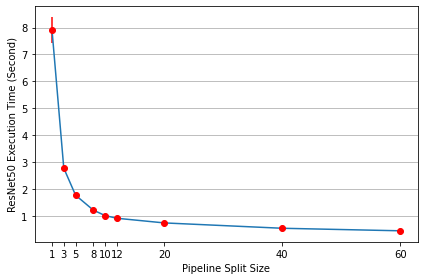

In [14]:
means = []
stds = []
split_sizes = [1, 3, 5, 8, 10, 12, 20, 40, 60]

for split_size in split_sizes:
    setup = "model = PipelineParallelResNet50(split_size=%d)" % split_size
    pp_run_times = timeit.repeat(
        stmt, setup, number=1, repeat=num_repeat, globals=globals())
    means.append(np.mean(pp_run_times))
    stds.append(np.std(pp_run_times))

fig, ax = plt.subplots()
ax.plot(split_sizes, means)
ax.errorbar(split_sizes, means, yerr=stds, ecolor='red', fmt='ro')
ax.set_ylabel('ResNet50 Execution Time (Second)')
ax.set_xlabel('Pipeline Split Size')
ax.set_xticks(split_sizes)
ax.yaxis.grid(True)
plt.tight_layout()
plt.savefig("split_size_tradeoff.png")
plt.show()
plt.close(fig)

The result shows that setting `split_size` to 12 achieves the fastest training speed, which leads to `3.75/2.43-1=54%` speedup. There are still opportunities to further accelerate the training process. For example, all operations on ``cuda:0`` is placed on its default stream. It means that computations on the next split cannot overlap with the copy operation of the prev split. However, as prev and next splits are different tensors, there is no problem to overlap one's computation with the other one's copy. The implementation need to use multiple streams on both GPUs, and different sub-network structures require different stream management strategies. As no general multi-stream solution works for all model parallel use cases, we will not discuss it in this tutorial.

## Credits

- Shen Li [https://mrshenli.github.io](https://mrshenli.github.io)
- PyTorch tutorial: [https://pytorch.org/tutorials/intermediate/model_parallel_tutorial.html](https://pytorch.org/tutorials/intermediate/model_parallel_tutorial.html)